In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import lmfit
import os
from scipy.optimize import curve_fit
def linear_fit(x, m, c):
    return m * x + c

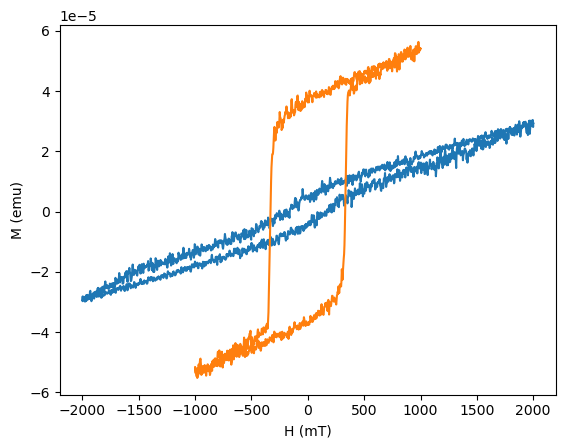

[ 649  656  659  662  663  676  677 1850 1851 1855 1859 1860 1868 1869]
{'Hc1': -206.03571428571428, 'Hc2': 178.45000000000002, 'Hc1_std': 31.544583803672836, 'Hc2_std': 23.262462712029684}
[1.26651050e-08 3.77254457e-06] [[ 2.25763141e-20 -2.82398381e-17]
 [-2.82398381e-17  3.95724084e-14]]
{'Ms_pos_ave': 3.5857087281034512e-06, 'Ms_neg_ave': -3.4286018482504062e-06, 'Ms_pos_std': 1.7973682518552497e-06, 'Ms_neg_std': 1.7784693584265777e-06, 'Ms_ave': 3.5071552881769287e-06, 'Ms_unc': 2.5285343366542284e-06}
Volume magnetisaiton =  17.55816309883566
[ 399 1000]
{'Hc1': -328.7, 'Hc2': 328.73, 'Hc1_std': 0.0, 'Hc2_std': 0.0}
[1.85354299e-08 3.55785676e-05] [[ 2.31381654e-19 -1.73746996e-16]
 [-1.73746996e-16  1.35342822e-13]]
{'Ms_pos_ave': 3.559390268213063e-05, 'Ms_neg_ave': -3.503863315565909e-05, 'Ms_pos_std': 1.2092538785785466e-06, 'Ms_neg_std': 1.4233245244055088e-06, 'Ms_ave': 3.531626791889486e-05, 'Ms_unc': 1.8676583318774947e-06}
Volume magnetisaiton =  176.80676822395986
Vol

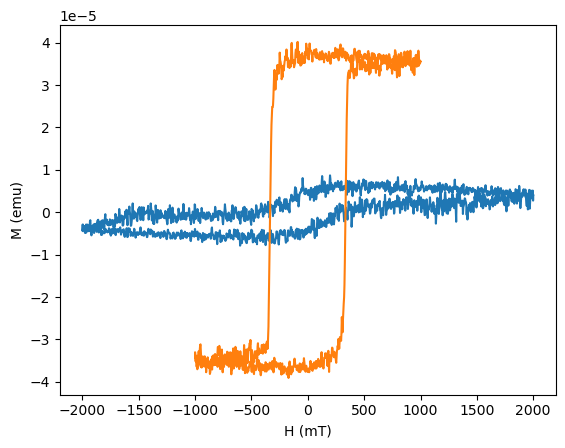

In [2]:
pAOMS1_folder = r'C:\Users\alexv\OneDrive - Imperial College London\Projects\Japan2024_May_KSAV\Japan_visit\P-AOMS\VSM\P-AOMS01_020524'
ip_file = 'AV-pAOMS-01-SingleLCoPt-020524-IP_24-05-02-19_19_52.VSM'
oop_file = 'AV-pAOMS-01-SingleLCoPt-OOP-020524_24-05-02-19_05_33.VSM'

pAOMS1_ip_path = os.path.join(pAOMS1_folder,ip_file)
pAOMS1_oop_path = os.path.join(pAOMS1_folder,oop_file)

pAOMS1_ip_data = pd.read_csv(pAOMS1_ip_path, header=40,delimiter=',', encoding='latin1')
pAOMS1_oop_data = pd.read_csv(pAOMS1_oop_path, header=40,delimiter=',', encoding='latin1')

#print(pAOMS1_ip_data)
#print(pAOMS1_oop_data)

def find_linear_background(data, background_threshold = 1000):
    field, magnetization = data['H(Oe)'], data['M(emu)']
    mask = field > background_threshold
    data = {
        'field_back': field[mask].values,
        'mag_back': magnetization[mask].values
        }
    df = pd.DataFrame(data)

    # Remove NaNs from all arrays
    df = df.dropna()
    #df
    popt, pcov = curve_fit(linear_fit, df['field_back'], df['mag_back'])
    background = linear_fit(field, *popt)
    return(popt, pcov, background)

def find_coercive_field(data):
    field, magnetization = data['H(Oe)'], data['M(emu)']
    zero_crossings = np.where(np.diff(np.signbit(magnetization)))[0]
    print(zero_crossings)
    x1 = np.where(field[zero_crossings]<0)
    x2 = np.where(field[zero_crossings]>0)
    Hc1 = np.mean(field[zero_crossings[x1]])
    Hc2 = np.mean(field[zero_crossings[x2]])
    Hc1_std = np.std(field[zero_crossings[x1]])
    Hc2_std = np.std(field[zero_crossings[x2]])
    Hcs_summary = {'Hc1':Hc1,'Hc2':Hc2,'Hc1_std':Hc1_std,'Hc2_std':Hc2_std}
    return(Hcs_summary)

def plot_VSM(data, fig = None,ax = None, background = np.array([])):
    field, magnetization = data['H(Oe)'], data['M(emu)']
    if fig == None or ax == None:
        fig,ax = plt.subplots(1,1)
    if np.size(background) !=0:
        original_average = np.mean(magnetization)
        magnetization = data['M(emu)'] - background
        corrected_average = np.mean(magnetization)
        correction = original_average - corrected_average
        magnetization += correction

    ax.plot(field, magnetization)
    ax.set_xlabel('H (mT)')
    ax.set_ylabel('M (emu)')

def find_sat_mag(data, background_threshold, background):
    field, magnetization = data['H(Oe)'], data['M(emu)']
    #if np.size(background) !=0:
    original_average = np.mean(magnetization)
    magnetization = data['M(emu)'] - background
    corrected_average = np.mean(magnetization)
    correction = original_average - corrected_average
    magnetization += correction
    mask = np.abs(field) > background_threshold
    data = {
        'field_back': field[mask].values,
        'mag_back': magnetization[mask].values
        }
    df = pd.DataFrame(data)

    # Remove NaNs from all arrays
    df = df.dropna()
    pos_mask = df['mag_back']>0
    neg_mask = df['mag_back']<0
    mag_sat_pos_ave = np.mean(df['mag_back'][pos_mask])
    mag_sat_neg_ave = np.mean(df['mag_back'][neg_mask])
    mag_sat_pos_std = np.std(df['mag_back'][pos_mask])
    mag_sat_neg_std = np.std(df['mag_back'][neg_mask])
    mag_sat_summ = {'Ms_pos_ave':mag_sat_pos_ave,'Ms_neg_ave':mag_sat_neg_ave,'Ms_pos_std':mag_sat_pos_std,'Ms_neg_std':mag_sat_neg_std, 'Ms_ave':(mag_sat_pos_ave-mag_sat_neg_ave)/2,'Ms_unc':(mag_sat_pos_std**2+mag_sat_neg_std**2)**0.5}
    #print(df['mag_back'][pos_mask],pos_mask)
    return(mag_sat_summ)

    
fig,ax = plt.subplots(1,1)
plot_VSM(pAOMS1_ip_data, fig,ax)
plot_VSM(pAOMS1_oop_data, fig,ax)
plt.show()

pAOMS2_Hcs_ip = find_coercive_field(pAOMS1_ip_data)
print(pAOMS2_Hcs_ip)
popt,pcov,background_pAOMS1_ip = find_linear_background(pAOMS1_ip_data, background_threshold=500)
print(popt, pcov)

mag_sat_summ = find_sat_mag(pAOMS1_ip_data,1000,background_pAOMS1_ip)
print(mag_sat_summ)
volume = 1.99745e-7 # in unnits of cm^-3
print('Volume magnetisaiton = ',mag_sat_summ['Ms_ave']/volume)
pAOMS2_Hcs_oop = find_coercive_field(pAOMS1_oop_data)
print(pAOMS2_Hcs_oop)
popt,pcov,background_pAOMS1_oop = find_linear_background(pAOMS1_oop_data, background_threshold=500)
print(popt, pcov)
mag_sat_summ = find_sat_mag(pAOMS1_oop_data,500,background_pAOMS1_oop)
print(mag_sat_summ)

volume = 1.99745e-7 # in unnits of cm^-3
test_volume = 1.99745e-7/9.1*3.1 # in unnits of cm^-3
print('Volume magnetisaiton = ',mag_sat_summ['Ms_ave']/volume)
print('Volume magnetisaiton = ',mag_sat_summ['Ms_ave']/test_volume)


fig,ax = plt.subplots(1,1)
plot_VSM(pAOMS1_ip_data, fig,ax, background_pAOMS1_ip)
plot_VSM(pAOMS1_oop_data, fig,ax, background_pAOMS1_oop)
plt.show()

[ 673  675  678 1866]
{'Hc1': -391.82666666666665, 'Hc2': 350.17, 'Hc1_std': 10.314624999915853, 'Hc2_std': 0.0}
[2.38636839e-08 5.50274641e-05] [[ 8.33691696e-20 -2.08634228e-16]
 [-2.08634228e-16  5.29060125e-13]]
{'Ms_pos_ave': 5.5084824463639635e-05, 'Ms_neg_ave': -5.352115060389765e-05, 'Ms_pos_std': 1.662652419544496e-06, 'Ms_neg_std': 1.6168997089638864e-06, 'Ms_ave': 5.430298753376864e-05, 'Ms_unc': 2.3192192084976932e-06}
Volume magnetisaiton =  138.03680151951255
[ 753 1956]
{'Hc1': -508.55, 'Hc2': 511.9, 'Hc1_std': 0.0, 'Hc2_std': 0.0}
[1.22713277e-08 1.75095142e-04] [[ 2.25790213e-17 -3.27583363e-14]
 [-3.27583363e-14  4.75460202e-11]]
{'Ms_pos_ave': 0.00017509518740708448, 'Ms_neg_ave': -0.00017426170830787082, 'Ms_pos_std': 1.5124079887358178e-06, 'Ms_neg_std': 9.75455738248869e-07, 'Ms_ave': 0.00017467844785747766, 'Ms_unc': 1.7996921463613068e-06}
Volume magnetisaiton =  444.02813420983404


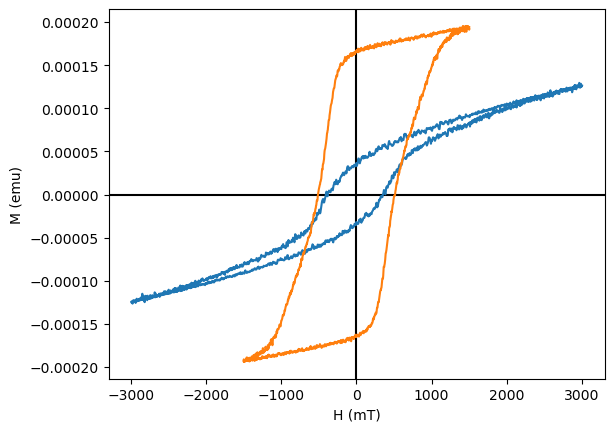

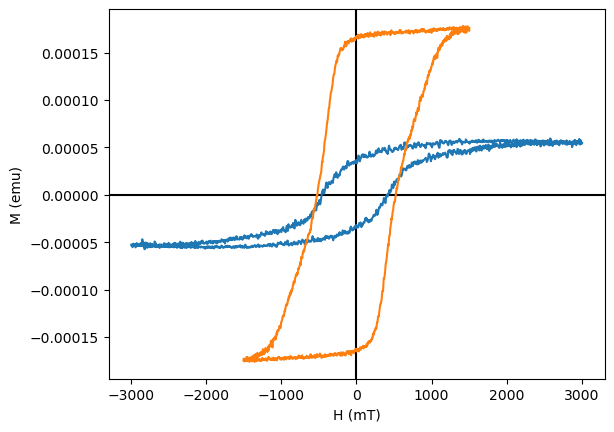

In [4]:
from scipy.optimize import curve_fit
def linear_fit(x, m, c):
    return m * x + c
pAOMS2_folder = r'C:\Users\alexv\OneDrive - Imperial College London\Projects\Japan2024_May_KSAV\Japan_visit\P-AOMS\VSM\P-AOMS02_020524'
ip_file = 'AV-030524-PAMOS02-multilayer-IPv4_24-05-03-17_40_54.VSM'
oop_file = 'AV-030524-PAMOS02-multilayer-OOPv3_24-05-03-17_21_16.VSM'

pAOMS2_ip_path = os.path.join(pAOMS2_folder,ip_file)
pAOMS2_oop_path = os.path.join(pAOMS2_folder,oop_file)

pAOMS2_ip_data = pd.read_csv(pAOMS2_ip_path, header=40,delimiter=',', encoding='latin1')
pAOMS2_oop_data = pd.read_csv(pAOMS2_oop_path, header=40,delimiter=',', encoding='latin1')

#print(pAOMS1_ip_data)
#print(pAOMS1_oop_data)

def find_coercive_field(data):
    field, magnetization = data['H(Oe)'], data['M(emu)']
    zero_crossings = np.where(np.diff(np.signbit(magnetization)))[0]
    print(zero_crossings)
    x1 = np.where(field[zero_crossings]<0)
    x2 = np.where(field[zero_crossings]>0)
    Hc1 = np.mean(field[zero_crossings[x1]])
    Hc2 = np.mean(field[zero_crossings[x2]])
    Hc1_std = np.std(field[zero_crossings[x1]])
    Hc2_std = np.std(field[zero_crossings[x2]])
    Hcs_summary = {'Hc1':Hc1,'Hc2':Hc2,'Hc1_std':Hc1_std,'Hc2_std':Hc2_std}
    return(Hcs_summary)

def find_linear_background(data, background_threshold = 1000):
    field, magnetization = data['H(Oe)'], data['M(emu)']
    mask = field > background_threshold
    data = {
        'field_back': field[mask].values,
        'mag_back': magnetization[mask].values
        }
    df = pd.DataFrame(data)

    # Remove NaNs from all arrays
    df = df.dropna()
    #df
    popt, pcov = curve_fit(linear_fit, df['field_back'], df['mag_back'])
    background = linear_fit(field, *popt)
    return(popt, pcov, background)

def find_sat_mag(data, background_threshold, background):
    field, magnetization = data['H(Oe)'], data['M(emu)']
    #if np.size(background) !=0:
    original_average = np.mean(magnetization)
    magnetization = data['M(emu)'] - background
    corrected_average = np.mean(magnetization)
    correction = original_average - corrected_average
    magnetization += correction
    mask = np.abs(field) > background_threshold
    data = {
        'field_back': field[mask].values,
        'mag_back': magnetization[mask].values
        }
    df = pd.DataFrame(data)

    # Remove NaNs from all arrays
    df = df.dropna()
    pos_mask = df['mag_back']>0
    neg_mask = df['mag_back']<0
    mag_sat_pos_ave = np.mean(df['mag_back'][pos_mask])
    mag_sat_neg_ave = np.mean(df['mag_back'][neg_mask])
    mag_sat_pos_std = np.std(df['mag_back'][pos_mask])
    mag_sat_neg_std = np.std(df['mag_back'][neg_mask])
    mag_sat_summ = {'Ms_pos_ave':mag_sat_pos_ave,'Ms_neg_ave':mag_sat_neg_ave,'Ms_pos_std':mag_sat_pos_std,'Ms_neg_std':mag_sat_neg_std, 'Ms_ave':(mag_sat_pos_ave-mag_sat_neg_ave)/2,'Ms_unc':(mag_sat_pos_std**2+mag_sat_neg_std**2)**0.5}
    #print(df['mag_back'][pos_mask],pos_mask)
    return(mag_sat_summ)

#def find_sat_magnetisation(data):#

pAOMS2_Hcs_ip = find_coercive_field(pAOMS2_ip_data)
print(pAOMS2_Hcs_ip)
popt,pcov,background_pAOMS2_ip = find_linear_background(pAOMS2_ip_data, background_threshold = 2000)
print(popt, pcov)
mag_sat_summ = find_sat_mag(pAOMS2_ip_data,2000,background_pAOMS2_ip)
print(mag_sat_summ)
volume = 3.93395e-7 # in unnits of cm^-3
print('Volume magnetisaiton = ',mag_sat_summ['Ms_ave']/volume)

pAOMS2_Hcs_oop = find_coercive_field(pAOMS2_oop_data)
print(pAOMS2_Hcs_oop)
popt,pcov,background_pAOMS2_oop = find_linear_background(pAOMS2_oop_data,background_threshold = 1400)
print(popt, pcov)
mag_sat_summ = find_sat_mag(pAOMS2_oop_data,1400,background_pAOMS2_oop)
print(mag_sat_summ)
volume = 3.93395e-7 # in unnits of cm^-3
print('Volume magnetisaiton = ',mag_sat_summ['Ms_ave']/volume)


def plot_VSM(data, fig = None,ax = None, background = np.array([])):
    field, magnetization = data['H(Oe)'], data['M(emu)']
    if fig == None or ax == None:
        fig,ax = plt.subplots(1,1)
    if np.size(background) !=0:
        original_average = np.mean(magnetization)
        magnetization = data['M(emu)'] - background
        corrected_average = np.mean(magnetization)
        correction = original_average - corrected_average
        magnetization += correction

    ax.plot(field, magnetization)
    ax.set_xlabel('H (mT)')
    ax.set_ylabel('M (emu)')
    
fig,ax = plt.subplots(1,1)
plot_VSM(pAOMS2_ip_data, fig,ax)
plot_VSM(pAOMS2_oop_data, fig,ax)
ax.axhline(0,zorder = -10, color = 'k')
ax.axvline(0, zorder = -10, color = 'k')
plt.show()

fig,ax = plt.subplots(1,1)
plot_VSM(pAOMS2_ip_data, fig,ax, background_pAOMS2_ip)
plot_VSM(pAOMS2_oop_data, fig,ax, background_pAOMS2_oop)
ax.axhline(0,zorder = -10, color = 'k')
ax.axvline(0, zorder = -10, color = 'k')
plt.show()

In [ ]:
print(np.mean(-391.82666666666665, 'Hc2': 350.17))

In [34]:
print((100000000000*(5e-9*10e-6)))

print(4*np.pi*1e-7*0.005/(2*np.pi*1e-9))

0.005000000000000001
1.0


[ 595  598  600 1796 1799 1800]
{'Hc1': -29.485, 'Hc2': 49.93749999999999, 'Hc1_std': 2.2750000000000004, 'Hc2_std': 19.88819671941124}
[2.35396278e-08 6.18151458e-05] [[ 3.40316044e-20 -3.64225829e-16]
 [-3.64225829e-16  5.67689831e-12]]
{'Ms_pos_ave': 6.657624559734081e-05, 'Ms_neg_ave': -6.632520221309426e-05, 'Ms_pos_std': 3.345312428577642e-05, 'Ms_neg_std': 3.365168924253408e-05, 'Ms_ave': 6.645072390521754e-05, 'Ms_unc': 4.7450476429174955e-05}
Volume magnetisaiton =  168.91603580426172
[310 910]


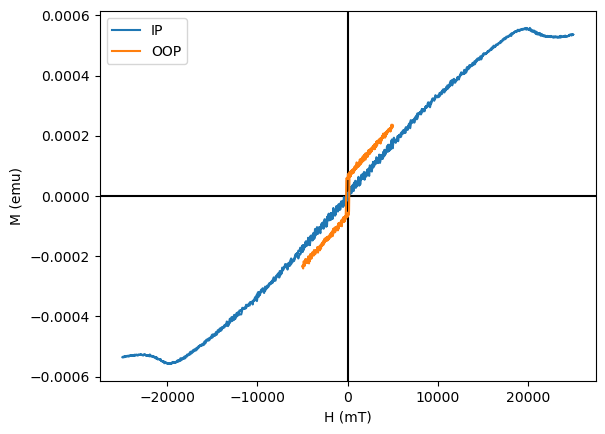

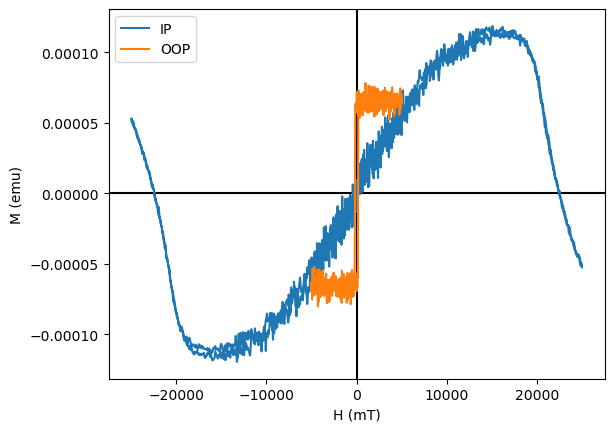

In [5]:
folder = r'C:\Users\alexv\OneDrive - Imperial College London\Projects\Japan2024_May_KSAV\Japan_visit\P-AOMS\VSM\190524-Remeasure'

from scipy.optimize import curve_fit
import pyperclip
import time

def linear_fit(x, m, c):
    return m * x + c
folder = r'C:\Users\alexv\OneDrive - Imperial College London\Projects\Japan2024_May_KSAV\Japan_visit\P-AOMS\VSM\190524-Remeasure'
ip_file = 'IP-RefFilm-AV7524-CoPtSing-2_24-05-10-10_00_17.VSM'
oop_file = 'OOP-RefFilm-AV7524-CoPtSing_24-05-10-09_43_01.VSM'

pAOMS2_ip_path = os.path.join(folder,ip_file)
pAOMS2_oop_path = os.path.join(folder,oop_file)

pAOMS2_ip_data = pd.read_csv(pAOMS2_ip_path, header=40,delimiter=',', encoding='latin1')
pAOMS2_oop_data = pd.read_csv(pAOMS2_oop_path, header=40,delimiter=',', encoding='latin1')

#print(pAOMS1_ip_data)
#print(pAOMS1_oop_data)

def find_coercive_field(data):
    field, magnetization = data['H(Oe)'], data['M(emu)']
    zero_crossings = np.where(np.diff(np.signbit(magnetization)))[0]
    print(zero_crossings)
    x1 = np.where(field[zero_crossings]<0)
    x2 = np.where(field[zero_crossings]>0)
    Hc1 = np.mean(field[zero_crossings[x1]])
    Hc2 = np.mean(field[zero_crossings[x2]])
    Hc1_std = np.std(field[zero_crossings[x1]])
    Hc2_std = np.std(field[zero_crossings[x2]])
    Hcs_summary = {'Hc1':Hc1,'Hc2':Hc2,'Hc1_std':Hc1_std,'Hc2_std':Hc2_std}
    return(Hcs_summary)

def find_linear_background(data, background_threshold = 1000):
    field, magnetization = data['H(Oe)'], data['M(emu)']
    mask = field > background_threshold
    data = {
        'field_back': field[mask].values,
        'mag_back': magnetization[mask].values
        }
    df = pd.DataFrame(data)

    # Remove NaNs from all arrays
    df = df.dropna()
    #df
    popt, pcov = curve_fit(linear_fit, df['field_back'], df['mag_back'])
    background = linear_fit(field, *popt)
    return(popt, pcov, background)

def find_sat_mag(data, background_threshold, background):
    field, magnetization = data['H(Oe)'], data['M(emu)']
    #if np.size(background) !=0:
    original_average = np.mean(magnetization)
    magnetization = data['M(emu)'] - background
    corrected_average = np.mean(magnetization)
    correction = original_average - corrected_average
    magnetization += correction
    mask = np.abs(field) > background_threshold
    data = {
        'field_back': field[mask].values,
        'mag_back': magnetization[mask].values
        }
    df = pd.DataFrame(data)

    # Remove NaNs from all arrays
    df = df.dropna()
    pos_mask = df['mag_back']>0
    neg_mask = df['mag_back']<0
    mag_sat_pos_ave = np.mean(df['mag_back'][pos_mask])
    mag_sat_neg_ave = np.mean(df['mag_back'][neg_mask])
    mag_sat_pos_std = np.std(df['mag_back'][pos_mask])
    mag_sat_neg_std = np.std(df['mag_back'][neg_mask])
    mag_sat_summ = {'Ms_pos_ave':mag_sat_pos_ave,'Ms_neg_ave':mag_sat_neg_ave,'Ms_pos_std':mag_sat_pos_std,'Ms_neg_std':mag_sat_neg_std, 'Ms_ave':(mag_sat_pos_ave-mag_sat_neg_ave)/2,'Ms_unc':(mag_sat_pos_std**2+mag_sat_neg_std**2)**0.5}
    #print(df['mag_back'][pos_mask],pos_mask)
    return(mag_sat_summ)

#def find_sat_magnetisation(data):#

pAOMS2_Hcs_ip = find_coercive_field(pAOMS2_ip_data)
print(pAOMS2_Hcs_ip)
popt,pcov,background_pAOMS2_ip = find_linear_background(pAOMS2_ip_data, background_threshold = 2000)
print(popt, pcov)
mag_sat_summ = find_sat_mag(pAOMS2_ip_data,2000,background_pAOMS2_ip)
print(mag_sat_summ)
volume = 3.93395e-7 # in unnits of cm^-3
print('Volume magnetisaiton = ',mag_sat_summ['Ms_ave']/volume)

IP_text = 'IP Hysteresis loop summary\n\
Hc1={} $\pm$ {}\n\
Hc2={} $\pm$ {}\n\
\n\
Ms_pos = {} $\pm$ {} \n\
Ms_neg = {} $\pm$ {} \n\
Ms_ave = {} $\pm$ {} \n\
\n\
Volume Magnetisation = {} \n\
\n\
Background_grad = {} \n\
Background_interc = {} \n\
      '.format(pAOMS2_Hcs_ip['Hc1'],pAOMS2_Hcs_ip['Hc1_std'],pAOMS2_Hcs_ip['Hc2'],pAOMS2_Hcs_ip['Hc2_std'],mag_sat_summ['Ms_pos_ave'],mag_sat_summ['Ms_pos_std'],mag_sat_summ['Ms_neg_ave'],mag_sat_summ['Ms_neg_std'],mag_sat_summ['Ms_ave'],mag_sat_summ['Ms_unc'],mag_sat_summ['Ms_ave']/volume,popt[1],popt[0])
pyperclip.copy(IP_text)
time.sleep(1)

pAOMS2_Hcs_oop = find_coercive_field(pAOMS2_oop_data)
#print(pAOMS2_Hcs_oop)
popt,pcov,background_pAOMS2_oop = find_linear_background(pAOMS2_oop_data,background_threshold = 1400)
#print(popt, pcov)
mag_sat_summ = find_sat_mag(pAOMS2_oop_data,1400,background_pAOMS2_oop)
#print(mag_sat_summ)
volume = 3.93395e-7 # in unnits of cm^-3
#print('Volume magnetisaiton = ',mag_sat_summ['Ms_ave']/volume)
OOP_text = 'OOP Hysteresis loop summary\n\
Hc1={} $\pm$ {}\n\
Hc2={} $\pm$ {}\n\
\n\
Ms_pos = {} $\pm$ {} \n\
Ms_neg = {} $\pm$ {} \n\
Ms_ave = {} $\pm$ {} \n\
\n\
Volume Magnetisation = {} \n\
\n\
Background_grad = {} \n\
Background_interc = {} \n\
      '.format(pAOMS2_Hcs_oop['Hc1'],pAOMS2_Hcs_oop['Hc1_std'],pAOMS2_Hcs_oop['Hc2'],pAOMS2_Hcs_oop['Hc2_std'],mag_sat_summ['Ms_pos_ave'],mag_sat_summ['Ms_pos_std'],mag_sat_summ['Ms_neg_ave'],mag_sat_summ['Ms_neg_std'],mag_sat_summ['Ms_ave'],mag_sat_summ['Ms_unc'],mag_sat_summ['Ms_ave']/volume,popt[1],popt[0])
pyperclip.copy(OOP_text)

def plot_VSM(data, fig = None,ax = None, background = np.array([]), label =''):
    field, magnetization = data['H(Oe)'], data['M(emu)']
    if fig == None or ax == None:
        fig,ax = plt.subplots(1,1)
    if np.size(background) !=0:
        original_average = np.mean(magnetization)
        magnetization = data['M(emu)'] - background
        corrected_average = np.mean(magnetization)
        correction = original_average - corrected_average
        magnetization += correction

    ax.plot(field, magnetization, label = label)
    ax.set_xlabel('H (mT)')
    ax.set_ylabel('M (emu)')
    
fig,ax = plt.subplots(1,1)
plot_VSM(pAOMS2_ip_data, fig,ax, label = 'IP')
plot_VSM(pAOMS2_oop_data, fig,ax, label = 'OOP')
ax.axhline(0,zorder = -10, color = 'k')
ax.axvline(0, zorder = -10, color = 'k')
plt.legend()
plt.show()

fig,ax = plt.subplots(1,1)
plot_VSM(pAOMS2_ip_data, fig,ax, background_pAOMS2_ip, label = 'IP')
plot_VSM(pAOMS2_oop_data, fig,ax, background_pAOMS2_oop, label = 'OOP')
ax.axhline(0,zorder = -10, color = 'k')
ax.axvline(0, zorder = -10, color = 'k')
plt.legend()
plt.show()

[ 472 1369 1375 1376]
{'Hc1': -385.23, 'Hc2': 424.09999999999997, 'Hc1_std': 0.0, 'Hc2_std': 51.442713769784724}
[2.87403152e-08 1.48263873e-04] [[ 1.15335450e-20 -1.15331026e-16]
 [-1.15331026e-16  1.24938646e-12]]
{'Ms_pos_ave': 0.0001360258284748511, 'Ms_neg_ave': -0.00013669505044839646, 'Ms_pos_std': 1.5327977348851285e-05, 'Ms_neg_std': 1.5254398006113774e-05, 'Ms_ave': 0.00013636043946162378, 'Ms_unc': 2.1625067586849898e-05}
Volume magnetisaiton =  1291.964938761891
[331 931]
OOP Hysteresis loop summary
Hc1=-535.06 $\pm$ 0.0
Hc2=534.98 $\pm$ 0.0

Ms_pos = 0.0001559615935015173 $\pm$ 4.38557488832031e-06 
Ms_neg = -0.0001577116498716753 $\pm$ 4.24829684399293e-06 
Ms_ave = 0.0001568366216865963 $\pm$ 6.105840906521066e-06 

Volume Magnetisation = 1485.9692234269392 

Background_grad = 3.849887747980488e-08 
Background_interc = 0.0001559624584065307 
      


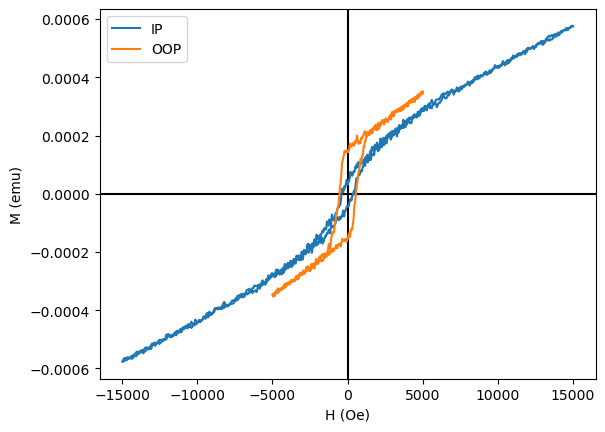

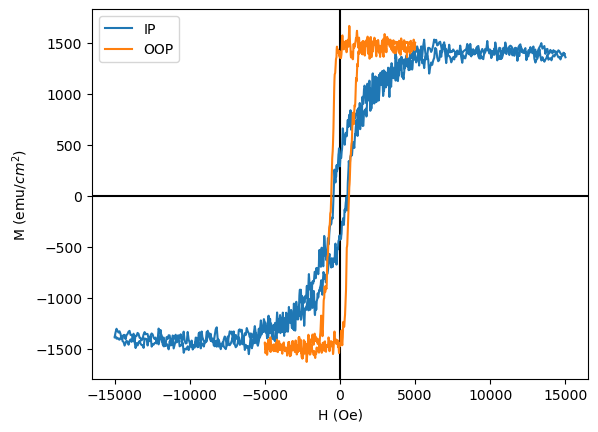

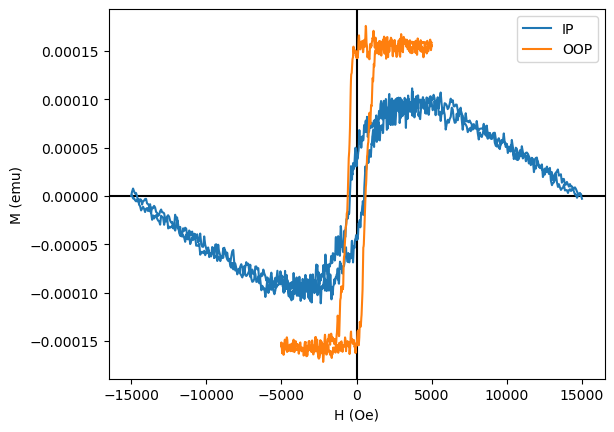

In [19]:
folder = r'C:\Users\alexv\OneDrive - Imperial College London\Projects\Japan2024_May_KSAV\Japan_visit\P-AOMS\VSM\190524-Remeasure'
import os
from scipy.optimize import curve_fit
import pyperclip
import time

def linear_fit(x, m, c):
    return m * x + c
folder = r'C:\Users\alexv\OneDrive - Imperial College London\Projects\Japan2024_May_KSAV\Japan_visit\P-AOMS\VSM\190524-Remeasure'
ip_file = 'IP-PAOMS02-AV20524-CoPtMulti5x-2_24-05-10-10_56_27.VSM'
oop_file = 'OOP-PAOMS02-AV20524-CoPtMulti5x-2_24-05-10-10_40_10.VSM'

pAOMS2_ip_path = os.path.join(folder,ip_file)
pAOMS2_oop_path = os.path.join(folder,oop_file)

pAOMS2_ip_data = pd.read_csv(pAOMS2_ip_path, header=40,delimiter=',', encoding='latin1')
pAOMS2_oop_data = pd.read_csv(pAOMS2_oop_path, header=40,delimiter=',', encoding='latin1')

#print(pAOMS1_ip_data)
#print(pAOMS1_oop_data)

def remove_field_data(data, threshold):
    field, magnetization = data['H(Oe)'], data['M(emu)']
    mask = np.abs(field) < threshold
    data = {
        'field_back': field[mask].values,
        'mag_back': magnetization[mask].values
        }
    df = pd.DataFrame(data)

    # Remove NaNs from all arrays
    df = df.dropna()
    data['H(Oe)'], data['M(emu)'] = df['field_back'], df['mag_back']
    return(data)


def find_coercive_field(data):
    field, magnetization = data['H(Oe)'], data['M(emu)']
    zero_crossings = np.where(np.diff(np.signbit(magnetization)))[0]
    print(zero_crossings)
    x1 = np.where(field[zero_crossings]<0)
    x2 = np.where(field[zero_crossings]>0)
    Hc1 = np.mean(field[zero_crossings[x1]])
    Hc2 = np.mean(field[zero_crossings[x2]])
    Hc1_std = np.std(field[zero_crossings[x1]])
    Hc2_std = np.std(field[zero_crossings[x2]])
    Hcs_summary = {'Hc1':Hc1,'Hc2':Hc2,'Hc1_std':Hc1_std,'Hc2_std':Hc2_std}
    return(Hcs_summary)

def find_linear_background(data, background_threshold = 1000, background_limit =None):
    field, magnetization = data['H(Oe)'], data['M(emu)']
    if background_limit  == None:
        mask = field > background_threshold
    else:
        mask = field > background_threshold and field < background_limit
    data = {
        'field_back': field[mask].values,
        'mag_back': magnetization[mask].values
        }
    df = pd.DataFrame(data)

    # Remove NaNs from all arrays
    df = df.dropna()
    #df
    popt, pcov = curve_fit(linear_fit, df['field_back'], df['mag_back'])
    background = linear_fit(field, *popt)
    return(popt, pcov, background)

#def find_sat_magnetisation(data):#

pAOMS2_ip_data = remove_field_data(pAOMS2_ip_data, threshold=15000)

pAOMS2_Hcs_ip = find_coercive_field(pAOMS2_ip_data)
print(pAOMS2_Hcs_ip)
popt,pcov,background_pAOMS2_ip = find_linear_background(pAOMS2_ip_data, background_threshold = 5000)
print(popt, pcov)
mag_sat_summ = find_sat_mag(pAOMS2_ip_data,2000,background_pAOMS2_ip)
print(mag_sat_summ)
volume = 3.93395e-7*(1.1*5/(1.1*5+2*5+5)) # in unnits of cm^-3
print('Volume magnetisaiton = ',mag_sat_summ['Ms_ave']/volume)

IP_text = 'IP Hysteresis loop summary\n\
Hc1={} $\pm$ {}\n\
Hc2={} $\pm$ {}\n\
\n\
Ms_pos = {} $\pm$ {} \n\
Ms_neg = {} $\pm$ {} \n\
Ms_ave = {} $\pm$ {} \n\
\n\
Volume Magnetisation = {} \n\
\n\
Background_grad = {} \n\
Background_interc = {} \n\
      '.format(pAOMS2_Hcs_ip['Hc1'],pAOMS2_Hcs_ip['Hc1_std'],pAOMS2_Hcs_ip['Hc2'],pAOMS2_Hcs_ip['Hc2_std'],mag_sat_summ['Ms_pos_ave'],mag_sat_summ['Ms_pos_std'],mag_sat_summ['Ms_neg_ave'],mag_sat_summ['Ms_neg_std'],mag_sat_summ['Ms_ave'],mag_sat_summ['Ms_unc'],mag_sat_summ['Ms_ave']/volume,popt[0],popt[1])
pyperclip.copy(IP_text)
time.sleep(1)
back_grad_ip = popt[0]

pAOMS2_Hcs_oop = find_coercive_field(pAOMS2_oop_data)
#print(pAOMS2_Hcs_oop)
popt,pcov,background_pAOMS2_oop = find_linear_background(pAOMS2_oop_data,background_threshold = 2000)
#print(popt, pcov)
mag_sat_summ = find_sat_mag(pAOMS2_oop_data,2000,background_pAOMS2_oop)
#print(mag_sat_summ)
volume = 3.93395e-7*(1.1*5/(1.1*5+2*5+5)) # in unnits of cm^-3
#print('Volume magnetisaiton = ',mag_sat_summ['Ms_ave']/volume)
OOP_text = 'OOP Hysteresis loop summary\n\
Hc1={} $\pm$ {}\n\
Hc2={} $\pm$ {}\n\
\n\
Ms_pos = {} $\pm$ {} \n\
Ms_neg = {} $\pm$ {} \n\
Ms_ave = {} $\pm$ {} \n\
\n\
Volume Magnetisation = {} \n\
\n\
Background_grad = {} \n\
Background_interc = {} \n\
      '.format(pAOMS2_Hcs_oop['Hc1'],pAOMS2_Hcs_oop['Hc1_std'],pAOMS2_Hcs_oop['Hc2'],pAOMS2_Hcs_oop['Hc2_std'],mag_sat_summ['Ms_pos_ave'],mag_sat_summ['Ms_pos_std'],mag_sat_summ['Ms_neg_ave'],mag_sat_summ['Ms_neg_std'],mag_sat_summ['Ms_ave'],mag_sat_summ['Ms_unc'],mag_sat_summ['Ms_ave']/volume,popt[0],popt[1])
pyperclip.copy(OOP_text)
print(OOP_text)

back_grad_oop = popt[0]

def plot_VSM(data, fig = None,ax = None, background = np.array([]), label ='', volume = None):
    field, magnetization = data['H(Oe)'], data['M(emu)']
    if fig == None or ax == None:
        fig,ax = plt.subplots(1,1)
    if np.size(background) !=0:
        original_average = np.mean(magnetization)
        magnetization = data['M(emu)'] - background
        corrected_average = np.mean(magnetization)
        correction = original_average - corrected_average
        magnetization += correction
    if volume!=None:
        magnetization = magnetization/volume
        ax.set_ylabel(r'M (emu/$cm^2$)')
    else:
        ax.set_ylabel(r'M (emu)')

    ax.plot(field, magnetization, label = label)
    ax.set_xlabel('H (Oe)')
    

def plot_VSM_linsub(data, fig = None,ax = None, background_grad = None, label ='',volume = None):
    field, magnetization = data['H(Oe)'], data['M(emu)']
    if fig == None or ax == None:
        fig,ax = plt.subplots(1,1)
    if background_grad !=None:
        original_average = np.mean(magnetization)
        magnetization = data['M(emu)'] - background_grad*field
        corrected_average = np.mean(magnetization)
        correction = original_average - corrected_average
        magnetization += correction
    if volume!=None:
        magnetization = magnetization/volume
        ax.set_ylabel(r'M (emu/$cm^2$)')
    else:
        ax.set_ylabel(r'M (emu)')

    ax.plot(field, magnetization, label = label)
    ax.set_xlabel('H (Oe)')

    
fig,ax = plt.subplots(1,1)
plot_VSM(pAOMS2_ip_data, fig,ax, label = 'IP')
plot_VSM(pAOMS2_oop_data, fig,ax, label = 'OOP')
ax.axhline(0,zorder = -10, color = 'k')
ax.axvline(0, zorder = -10, color = 'k')
plt.legend()
plt.show()

fig,ax = plt.subplots(1,1)
plot_VSM(pAOMS2_ip_data, fig,ax, background_pAOMS2_ip, label = 'IP',volume=volume)
plot_VSM(pAOMS2_oop_data, fig,ax, background_pAOMS2_oop, label = 'OOP',volume=volume)
ax.axhline(0,zorder = -10, color = 'k')
ax.axvline(0, zorder = -10, color = 'k')
plt.legend()
plt.show()

fig,ax = plt.subplots(1,1)
plot_VSM_linsub(pAOMS2_ip_data, fig,ax, back_grad_oop, label = 'IP')
plot_VSM_linsub(pAOMS2_oop_data, fig,ax, back_grad_oop, label = 'OOP')
ax.axhline(0,zorder = -10, color = 'k')
ax.axvline(0, zorder = -10, color = 'k')
plt.legend()
plt.show()

[ 455  456  463 1341 1342 1346 1348 1349 1350 1352 1356 1362]
{'Hc1': -136.964, 'Hc2': 113.69285714285716, 'Hc1_std': 60.10908137710973, 'Hc2_std': 87.46185776248586}
[2.77338069e-08 3.88413400e-05] [[ 1.12552074e-20 -1.12548539e-16]
 [-1.12548539e-16  1.21925581e-12]]
{'Ms_pos_ave': 3.508449749684784e-05, 'Ms_neg_ave': -3.530027724204752e-05, 'Ms_pos_std': 7.5286663695289245e-06, 'Ms_neg_std': 7.878383202229058e-06, 'Ms_ave': 3.519238736944768e-05, 'Ms_unc': 1.0897235391824884e-05}
Volume magnetisaiton =  1457.2960221891367
[323 923]
OOP Hysteresis loop summary
Hc1=-401.68 $\pm$ 0.0
Hc2=402.11 $\pm$ 0.0

Ms_pos = 3.469683388421538e-05 $\pm$ 5.190371151861082e-06 
Ms_neg = -3.460294981311363e-05 $\pm$ 5.416365718405955e-06 
Ms_ave = 3.4649891848664506e-05 $\pm$ 7.501797803833091e-06 

Volume Magnetisation = 1434.831602364664 

Background_grad = 3.4696200715825506e-05 
Background_interc = 3.7706717309561724e-08 
      


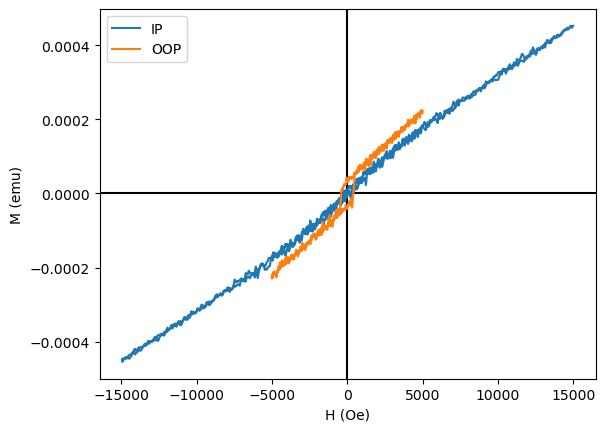

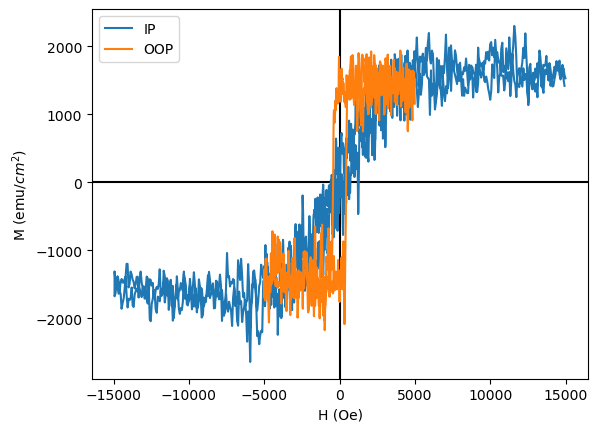

In [17]:
folder = r'C:\Users\alexv\OneDrive - Imperial College London\Projects\Japan2024_May_KSAV\Japan_visit\P-AOMS\VSM\190524-Remeasure'

from scipy.optimize import curve_fit
import pyperclip
import time

def linear_fit(x, m, c):
    return m * x + c
folder = r'C:\Users\alexv\OneDrive - Imperial College London\Projects\Japan2024_May_KSAV\Japan_visit\P-AOMS\VSM\190524-Remeasure'
ip_file = 'IP-PAOMS01-AV20524-CoPtSing-2_24-05-10-10_17_34.VSM'
oop_file = 'OOP-PAOMS01-AV20524-CoPtSing-2_24-05-10-10_27_15.VSM'

pAOMS2_ip_path = os.path.join(folder,ip_file)
pAOMS2_oop_path = os.path.join(folder,oop_file)

pAOMS2_ip_data = pd.read_csv(pAOMS2_ip_path, header=40,delimiter=',', encoding='latin1')
pAOMS2_oop_data = pd.read_csv(pAOMS2_oop_path, header=40,delimiter=',', encoding='latin1')

#print(pAOMS1_ip_data)
#print(pAOMS1_oop_data)

def find_coercive_field(data):
    field, magnetization = data['H(Oe)'], data['M(emu)']
    zero_crossings = np.where(np.diff(np.signbit(magnetization)))[0]
    print(zero_crossings)
    x1 = np.where(field[zero_crossings]<0)
    x2 = np.where(field[zero_crossings]>0)
    Hc1 = np.mean(field[zero_crossings[x1]])
    Hc2 = np.mean(field[zero_crossings[x2]])
    Hc1_std = np.std(field[zero_crossings[x1]])
    Hc2_std = np.std(field[zero_crossings[x2]])
    Hcs_summary = {'Hc1':Hc1,'Hc2':Hc2,'Hc1_std':Hc1_std,'Hc2_std':Hc2_std}
    return(Hcs_summary)

def remove_field_data(data, threshold):
    field, magnetization = data['H(Oe)'], data['M(emu)']
    mask = np.abs(field) < threshold
    data = {
        'field_back': field[mask].values,
        'mag_back': magnetization[mask].values
        }
    df = pd.DataFrame(data)

    # Remove NaNs from all arrays
    df = df.dropna()
    data['H(Oe)'], data['M(emu)'] = df['field_back'], df['mag_back']
    return(data)

def find_linear_background(data, background_threshold = 1000):
    field, magnetization = data['H(Oe)'], data['M(emu)']
    mask = field > background_threshold
    data = {
        'field_back': field[mask].values,
        'mag_back': magnetization[mask].values
        }
    df = pd.DataFrame(data)

    # Remove NaNs from all arrays
    df = df.dropna()
    #df
    popt, pcov = curve_fit(linear_fit, df['field_back'], df['mag_back'])
    background = linear_fit(field, *popt)
    return(popt, pcov, background)

#def find_sat_magnetisation(data):#

pAOMS2_ip_data = remove_field_data(pAOMS2_ip_data, 15000)

pAOMS2_Hcs_ip = find_coercive_field(pAOMS2_ip_data)
print(pAOMS2_Hcs_ip)
popt,pcov,background_pAOMS2_ip = find_linear_background(pAOMS2_ip_data, background_threshold = 5000)
print(popt, pcov)
mag_sat_summ = find_sat_mag(pAOMS2_ip_data,2000,background_pAOMS2_ip)
print(mag_sat_summ)
volume = 1.99745e-7 # in unnits of cm^-3
volume = 0.241491e-7
print('Volume magnetisaiton = ',mag_sat_summ['Ms_ave']/volume)

IP_text = 'IP Hysteresis loop summary\n\
Hc1={} $\pm$ {}\n\
Hc2={} $\pm$ {}\n\
\n\
Ms_pos = {} $\pm$ {} \n\
Ms_neg = {} $\pm$ {} \n\
Ms_ave = {} $\pm$ {} \n\
\n\
Volume Magnetisation = {} \n\
\n\
Background_grad = {} \n\
Background_interc = {} \n\
      '.format(pAOMS2_Hcs_ip['Hc1'],pAOMS2_Hcs_ip['Hc1_std'],pAOMS2_Hcs_ip['Hc2'],pAOMS2_Hcs_ip['Hc2_std'],mag_sat_summ['Ms_pos_ave'],mag_sat_summ['Ms_pos_std'],mag_sat_summ['Ms_neg_ave'],mag_sat_summ['Ms_neg_std'],mag_sat_summ['Ms_ave'],mag_sat_summ['Ms_unc'],mag_sat_summ['Ms_ave']/volume,popt[1],popt[0])
pyperclip.copy(IP_text)
time.sleep(1)

pAOMS2_Hcs_oop = find_coercive_field(pAOMS2_oop_data)
#print(pAOMS2_Hcs_oop)
popt,pcov,background_pAOMS2_oop = find_linear_background(pAOMS2_oop_data,background_threshold = 1400)
#print(popt, pcov)
mag_sat_summ = find_sat_mag(pAOMS2_oop_data,1400,background_pAOMS2_oop)
#print(mag_sat_summ)
volume = 0.241491e-7#1.99745e-7 # in unnits of cm^-3
#1.99745e-7#
#0.12087912087912087912087912087912
#print('Volume magnetisaiton = ',mag_sat_summ['Ms_ave']/volume)
OOP_text = 'OOP Hysteresis loop summary\n\
Hc1={} $\pm$ {}\n\
Hc2={} $\pm$ {}\n\
\n\
Ms_pos = {} $\pm$ {} \n\
Ms_neg = {} $\pm$ {} \n\
Ms_ave = {} $\pm$ {} \n\
\n\
Volume Magnetisation = {} \n\
\n\
Background_grad = {} \n\
Background_interc = {} \n\
      '.format(pAOMS2_Hcs_oop['Hc1'],pAOMS2_Hcs_oop['Hc1_std'],pAOMS2_Hcs_oop['Hc2'],pAOMS2_Hcs_oop['Hc2_std'],mag_sat_summ['Ms_pos_ave'],mag_sat_summ['Ms_pos_std'],mag_sat_summ['Ms_neg_ave'],mag_sat_summ['Ms_neg_std'],mag_sat_summ['Ms_ave'],mag_sat_summ['Ms_unc'],mag_sat_summ['Ms_ave']/volume,popt[1],popt[0])
pyperclip.copy(OOP_text)
print(OOP_text)

def plot_VSM(data, fig = None,ax = None, background = np.array([]), label ='', volume = None):
    field, magnetization = data['H(Oe)'], data['M(emu)']
    if fig == None or ax == None:
        fig,ax = plt.subplots(1,1)
    if np.size(background) !=0:
        original_average = np.mean(magnetization)
        magnetization = data['M(emu)'] - background
        corrected_average = np.mean(magnetization)
        correction = original_average - corrected_average
        magnetization += correction
    if volume!=None:
        magnetization = magnetization/volume
        ax.set_ylabel(r'M (emu/$cm^2$)')
    else:
        ax.set_ylabel(r'M (emu)')

    ax.plot(field, magnetization, label = label)
    ax.set_xlabel('H (Oe)')
    

def plot_VSM_linsub(data, fig = None,ax = None, background_grad = None, label ='',volume = None):
    field, magnetization = data['H(Oe)'], data['M(emu)']
    if fig == None or ax == None:
        fig,ax = plt.subplots(1,1)
    if background_grad !=None:
        original_average = np.mean(magnetization)
        magnetization = data['M(emu)'] - background_grad*field
        corrected_average = np.mean(magnetization)
        correction = original_average - corrected_average
        magnetization += correction
    if volume!=None:
        magnetization = magnetization/volume
        ax.set_ylabel(r'M (emu/$cm^2$)')
    else:
        ax.set_ylabel(r'M (emu)')

    ax.plot(field, magnetization, label = label)
    ax.set_xlabel('H (Oe)')
    
fig,ax = plt.subplots(1,1)
plot_VSM(pAOMS2_ip_data, fig,ax, label = 'IP')
plot_VSM(pAOMS2_oop_data, fig,ax, label = 'OOP')
ax.axhline(0,zorder = -10, color = 'k')
ax.axvline(0, zorder = -10, color = 'k')
plt.legend()
plt.show()

fig,ax = plt.subplots(1,1)
plot_VSM(pAOMS2_ip_data, fig,ax, background_pAOMS2_ip, label = 'IP', volume=volume)
plot_VSM(pAOMS2_oop_data, fig,ax, background_pAOMS2_oop, label = 'OOP',volume=volume)
ax.axhline(0,zorder = -10, color = 'k')
ax.axvline(0, zorder = -10, color = 'k')
plt.legend()
plt.show()